## Libraries Import

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization, Embedding,Dropout, GlobalMaxPooling1D, LeakyReLU, Conv1D, MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [3]:
#suppressing the warnings
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Dataset Reading

In [4]:
dataset = pd.read_csv('/content/Data.csv', engine='python')
dataset.drop(['Date', 'Top21', 'Top22', 'Top23', 'Top24', 'Top25'], axis=1, inplace=True)
dataset.head(3)

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20
0,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,Derby raise a glass to Strupar's debut double,"Southgate strikes, Leeds pay the penalty",Hammers hand Robson a youthful lesson,Saints party like it's 1999,Wear wolves have turned into lambs,Stump mike catches testy Gough's taunt,Langer escapes to hit 167,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl's successor drawn into scandal,The difference between men and women,"Sara Denver, nurse turned solicitor"
1,0,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,Hopkins 'furious' at Foster's lack of Hannibal...,Has Cubie killed fees?,A tale of two tails,I say what I like and I like what I say,"Elbows, Eyes and Nipples",Task force to assess risk of asteroid collision,How I found myself at last,On the critical list,The timing of their lives,Dear doctor,Irish court halts IRA man's extradition to Nor...,Burundi peace initiative fades after rebels re...
2,0,Coventry caught on counter by Flo,United's rivals on the road to Rio,Thatcher issues defence before trial by video,Police help Smith lay down the law at Everton,Tale of Trautmann bears two more retellings,England on the rack,Pakistan retaliate with call for video of Walsh,Cullinan continues his Cape monopoly,McGrath puts India out of their misery,Blair Witch bandwagon rolls on,Pele turns up heat on Ferguson,Party divided over Kohl slush fund scandal,Manchester United (England),Women in record South Pole walk,Vasco da Gama (Brazil),South Melbourne (Australia),Necaxa (Mexico),Real Madrid (Spain),Raja Casablanca (Morocco),Corinthians (Brazil)


In [5]:
dataset['Annotation'] = " "
dataset.loc[dataset['Label'] == 0, 'Annotation'] = 'Stock Price Stay Same Or Decreased'
dataset.loc[dataset['Label'] == 1, 'Annotation'] = 'Stock Price Increased'
dataset.sample(3)

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Annotation
1758,1,Renegade ex-MI6 officer will not be prosecuted,Spectator to apologise for slur on DPP,Sheffield reverses its fortunes at the cuttin...,Watchdog's blessing for union cash,Rail users face years of price rises to pay fo...,Bush and Blair threaten new Sudan sanctions,Watchdog reveals cost overruns on road schemes...,No pardon for Admiral Byng. The MoD don't want...,OECD rebukes Britain for dropping Saudi arms d...,Simon Hoggart's sketch,Lords vote resoundingly against plans for refo...,Ten turbulent years in the hot seat of Ulster ...,Republic's PM tells why he still wants a unite...,Jon Henley's diary,Sarah Crown: On the 1839 Newport uprising,Nancy Sinatra,Phil Spector,Judge Larry Fidler,Ronnie Spector,Leonard Cohen,Stock Price Increased
465,0,Springboks coast to victory over Italy,Bristol 31 - 17 Bath,Women's football,Tootenham v Arsenal: Big Ron's chalkboard,Scottish round-up,Draw offers up lucrative derby,Burnley crack open the claret,Recently defeated Bayern Munich face Mancheste...,Lewes 0 - 2 Stoke City,Fulham 3 - 1 Newcastle United,Tranmere Rovers 4 - 1 Brigg Town,Wolverhampton Wand 0 - 0 Sheffield Wednesday,Manchester United 2 - 0 Leicester City,Barnet 0 - 0 Carlisle United,Blackburn Rover 1 - 1 Liverpool,Bedford Town 0 - 0 Peterborough,Gillingham 0 - 0 Watford,Derby County 1 - 0 Southampton,Ipswich Town 1 - 2 Bolton Wanderers,Sunderland 2 - 0 Leeds United,Stock Price Stay Same Or Decreased
1377,0,Newcastle make �16m Owen bid,Liverpool could face Chelsea,Carling Cup round-up,Aliadi�re moves to West Ham,Blackburn Rovers 0 - 0 Tottenham Hotspur,Bolton Wanderers 2 - 0 Newcastle United,Philip Bobbitt: How to ruin a milestone consti...,Slipper of the Yard dies without quite getting...,Police liberate stolen ornaments,Nokia and Motorola widen sales gap,Stead & Simpson considers offers after decidin...,Jarvis increases debts to stay afloat,Costa Coffee hopes to convert a nation of chai...,Hopes of bidding war for fashion chain,Analysis: Approaches don't always pay off,Neil Hume: market forces,Notebook,"Country diary: The Burren, Ireland",Sadek Hamid: Silver-bullet solutions obscure y...,Calendar girls,Stock Price Stay Same Or Decreased


## Target Class Distribution

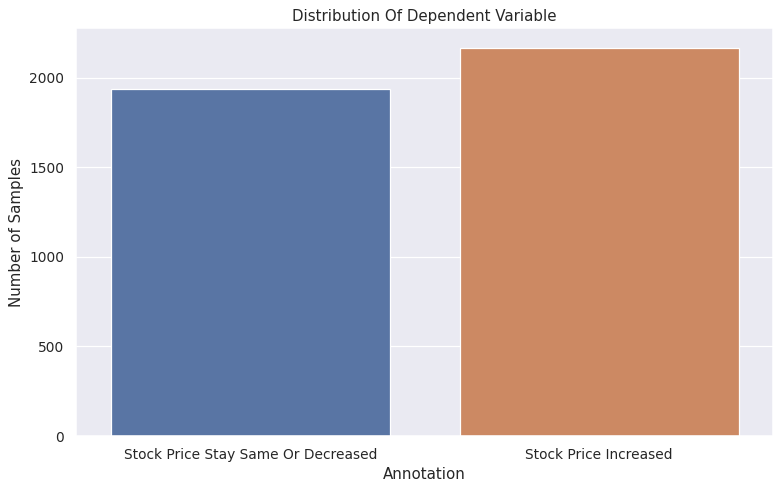

In [6]:
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['figure.dpi'] = 90
sns.set(style='darkgrid')

sns.countplot('Annotation', data=dataset)
plt.ylabel("Number of Samples")
plt.title('Distribution Of Dependent Variable')
plt.show()

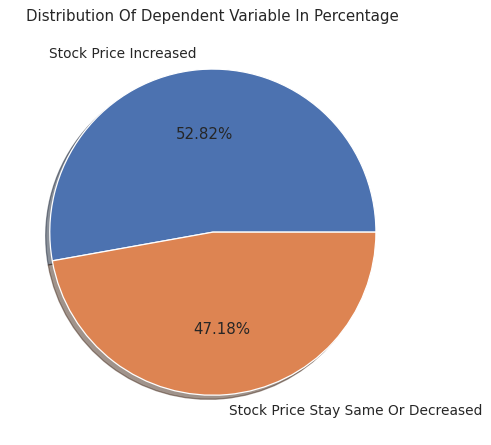

In [7]:
dataset['Annotation'].value_counts().plot.pie(autopct='%1.2f%%', shadow=True)
plt.title('Distribution Of Dependent Variable In Percentage')
plt.ylabel("")
plt.show()

## Merging All Columns Into One

In [8]:
dataset['Text'] = dataset[dataset.columns[1:]].apply(lambda x: ' '.join(x.dropna().astype(str)),axis=1)

In [9]:
dataset["Text"][0]

"A 'hindrance to operations': extracts from the leaked reports Scorecard Hughes' instant hit buoys Blues Jack gets his skates on at ice-cold Alex Chaos as Maracana builds up for United Depleted Leicester prevail as Elliott spoils Everton's party Hungry Spurs sense rich pickings Gunners so wide of an easy target Derby raise a glass to Strupar's debut double Southgate strikes, Leeds pay the penalty Hammers hand Robson a youthful lesson Saints party like it's 1999 Wear wolves have turned into lambs Stump mike catches testy Gough's taunt Langer escapes to hit 167 Flintoff injury piles on woe for England Hunters threaten Jospin with new battle of the Somme Kohl's successor drawn into scandal The difference between men and women Sara Denver, nurse turned solicitor Stock Price Stay Same Or Decreased"

In [10]:
dataset[:1]

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Annotation,Text
0,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,Derby raise a glass to Strupar's debut double,"Southgate strikes, Leeds pay the penalty",Hammers hand Robson a youthful lesson,Saints party like it's 1999,Wear wolves have turned into lambs,Stump mike catches testy Gough's taunt,Langer escapes to hit 167,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl's successor drawn into scandal,The difference between men and women,"Sara Denver, nurse turned solicitor",Stock Price Stay Same Or Decreased,A 'hindrance to operations': extracts from the...


## Text Cleaning

In [11]:
!pip -q install contractions
import contractions
import unicodedata

     |████████████████████████████████| 327kB 5.2MB/s 
     |████████████████████████████████| 286kB 19.5MB/s 


In [12]:
def remove_accented(x):
  x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return x

In [13]:
def get_clean(X):
  X = str(X).lower()
  X = X.replace('\\', ' ').replace('_', ' ').replace('.', ' ').replace(':', '')
  X = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',"",  X)
  X = re.sub(r'\brt\b', '', X).strip()
  X = re.sub('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});',"", X)
  X = re.sub(r'[^\w\d\s]+','', X)
  X = ' '.join(X.split())
  X = BeautifulSoup(X, 'lxml').get_text().strip()
  X = remove_accented(X)
  X = re.sub(r'[^\w ]+','',X)
  X = re.sub("(.)\\1{2,}", "\\1", X)
  X = contractions.fix(X)
  #X = ' '.join([word for word  in X.split() if word not in stopwords])
  return X

In [14]:
#cleaning
dataset['Text'] = dataset['Text'].apply(lambda x: get_clean(x)) 

In [15]:
dataset["Text"][3]

'pilgrim knows how to progress thatcher facing ban mcilroy calls for irish fighting spirit leicester bin stadium blueprint united braced for mexican wave auntie back in fashion even if the dress looks a bit tatty shoaib appeal goes to the top hussain hurt by shambles but lays blame on earlier damage englands decade of disasters revenge is sweet for jubilant cronje our choice not theirs profile of former us nazi party officer william pierce new evidence shows record of war crimes suspect was not investigated the rise of the supernerds written on the body putin admits yeltsin quit to give him a head start bbc worst hit as digital tv begins to bite how much can you pay for christmas glitches upending a table chopping a line and scoring a goal stock price increased'

## Word Cloud Representation

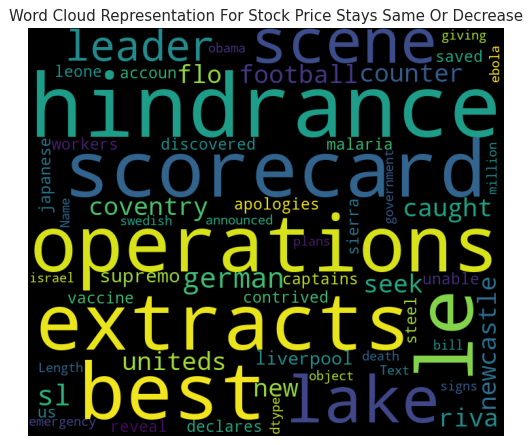

In [ ]:
wc = str(dataset[dataset['Label']==0].Text)
word_cloud = WordCloud(width=700, height=600, max_font_size=150).generate(wc)
plt.imshow(word_cloud)
plt.title('Word Cloud Representation For Stock Price Stays Same Or Decrease')
plt.axis('off')
plt.show()

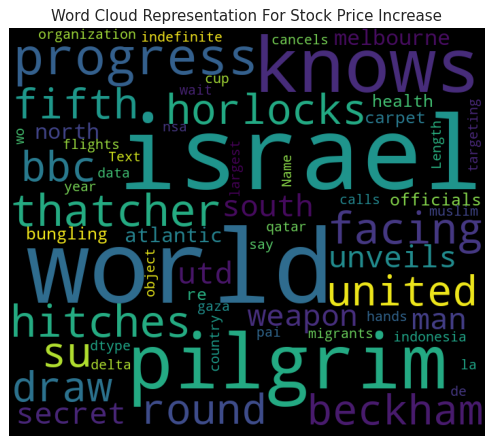

In [ ]:
wc = str(dataset[dataset['Label']==1].Text)
word_cloud = WordCloud(width=700, height=600, max_font_size=150).generate(wc)
plt.imshow(word_cloud)
plt.title('Word Cloud Representation For Stock Price Increase')
plt.axis('off')
plt.show()

## Data Preparation

In [16]:
X_df = dataset['Text']
X_df = pd.DataFrame({'Text':X_df.values})
X_df.sample(3)

,Text
20,double delight for shearer even ferguson wants...
1928,special focus on mental health lynn young the ...
560,baxter to take medal appeal to the top sport i...


In [17]:
y_df = dataset['Label']
y_df = pd.DataFrame({'Label':y_df.values})
y_df.sample(3)

,Label
830,0
1456,1
1552,1


## Converting Text Into Machine Understandable Numeric Form

In [18]:
#Tokenization
token = Tokenizer()
token.fit_on_texts(X_df['Text'])

In [19]:
vocab_size = len(token.word_index) + 1
print('The size of vocab:', vocab_size)

The size of vocab: 52453


In [20]:
encoded_text = token.texts_to_sequences(X_df['Text'])

In [21]:
max_length = len(X_df['Text'].max()) + 10
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [22]:
print(f'Shape of data: {X.shape, y_df.shape}')

Shape of data: ((4101, 744), (4101, 1))


## Dividing The Data Into Train & Test 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y_df, test_size=0.2, random_state=0, stratify=y_df)

In [24]:
print(f'Shape of Training data: {X_train.shape, y_train.shape}')
print(f'Shape of Test data: {X_test.shape, y_test.shape}')

Shape of Training data: ((3280, 744), (3280, 1))
Shape of Test data: ((821, 744), (821, 1))


## Model Creation

In [59]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(40, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Conv1D(80, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(20, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

## Understanding The Model

In [60]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 744, 100)          5245300   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 743, 40)           8040      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 371, 40)           0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 371, 40)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 370, 80)           6480      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 185, 80)           0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 185, 80)          

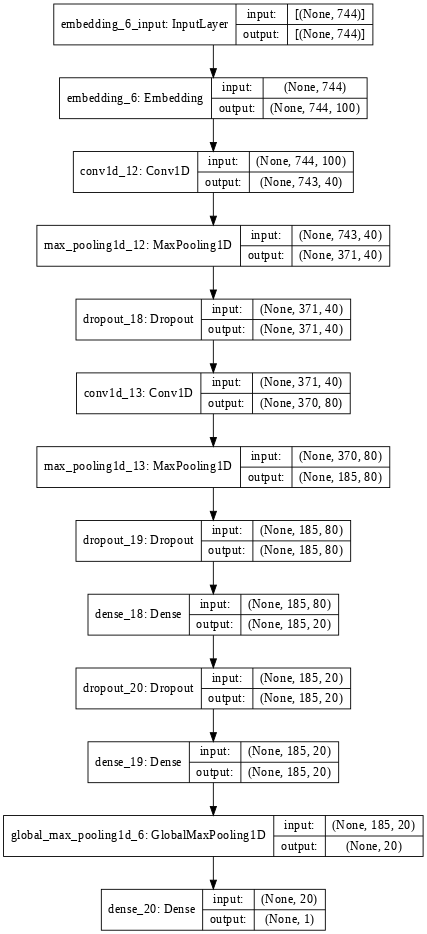

In [61]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=64)

## Model Training

In [62]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
r = model.fit(X_train, y_train, epochs=5,batch_size=10, validation_data=(X_test, y_test))

Epoch 1/5
328/328 [==============================] - 33s 98ms/step - loss: 0.2511 - accuracy: 0.4805 - val_loss: 0.2474 - val_accuracy: 0.5286
Epoch 2/5
328/328 [==============================] - 32s 97ms/step - loss: 0.2446 - accuracy: 0.6331 - val_loss: 0.1903 - val_accuracy: 0.9817
Epoch 3/5
328/328 [==============================] - 32s 96ms/step - loss: 0.1648 - accuracy: 0.9412 - val_loss: 0.0874 - val_accuracy: 0.9805
Epoch 4/5
328/328 [==============================] - 32s 96ms/step - loss: 0.0544 - accuracy: 0.9740 - val_loss: 0.0443 - val_accuracy: 0.9963
Epoch 5/5
328/328 [==============================] - 32s 97ms/step - loss: 0.0162 - accuracy: 0.9905 - val_loss: 0.0265 - val_accuracy: 0.9988


## Model Accuracy

In [63]:
import math   
print(f'The traning accuracy of model is {math.floor(r.history["accuracy"][-1] * 100)} %')
print(f'The validation accuracy of model is {math.floor(r.history["val_accuracy"][-1] * 100)} %')

The traning accuracy of model is 98 %
The validation accuracy of model is 99 %


## Model Loss

In [64]:
print(f'The traning loss of model is {r.history["loss"][-1]:.4}')
print(f'The validation loss of model is {r.history["val_loss"][-1]:.4}')

The traning loss of model is 0.01452
The validation loss of model is 0.0265


## Model Loss Visualization

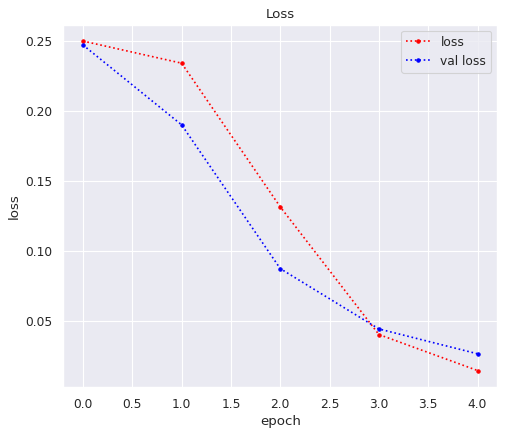

In [65]:
plt.rcParams['figure.figsize'] = [7,6]
plt.rcParams['figure.dpi'] = 80
plt.title('Loss')
plt.plot(r.history['loss'], ".:", label='loss', linewidth=1.5, color="red")
plt.plot(r.history['val_loss'], ".:", label='val loss', linewidth=1.5, color="blue")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Model Accuracy Visualization

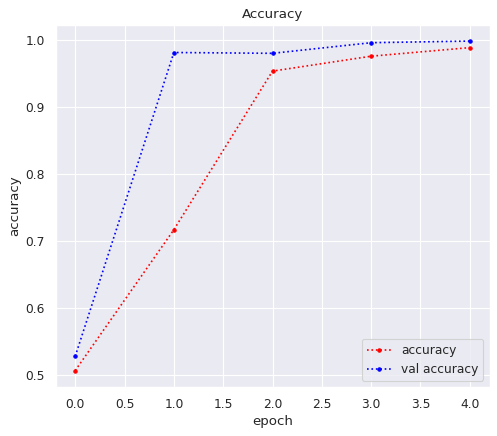

In [66]:
plt.title('Accuracy')
plt.plot(r.history['accuracy'], ".:", label='accuracy', linewidth=1.5, color="red")
plt.plot(r.history['val_accuracy'], ".:", label='val accuracy', linewidth=1.5, color="blue")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Saving The Model

In [67]:
model.save('stock_price_behaviour_prediction.h5')

## Making Predictions With Model

In [68]:
y_pred = model.predict_classes(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
classes = ['Stock Price Same or Decreases', 'Stock Price Increase']

## Confusion Matrix

In [69]:
!pip -q install mlxtend

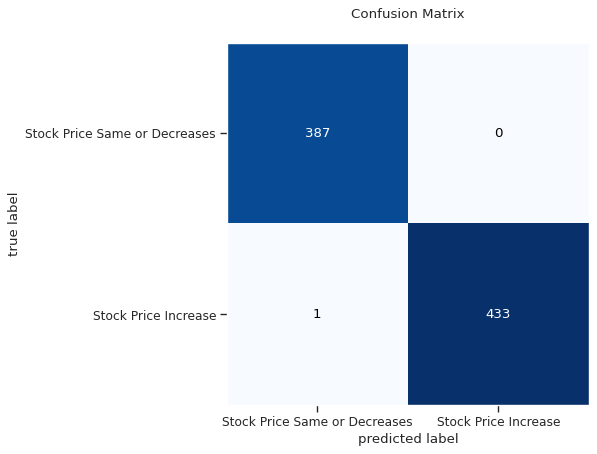

In [70]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(cnf_matrix)
ax.set_xticklabels([''] + list(classes))
ax.set_yticklabels([''] + list(classes))
plt.title('Confusion Matrix')
plt.show()
plt.show()

## Receiver Operating Characteristics (ROC)

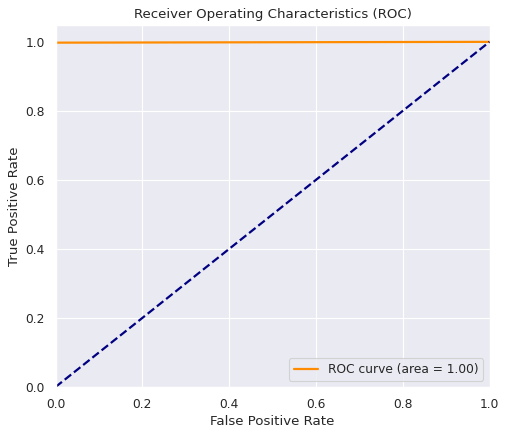

In [71]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc="lower right")
plt.show()

## Classification Report

In [72]:
from sklearn.metrics import classification_report
clf_report = classification_report(y_test, y_pred, target_names= ['Stock Price Same or Decreases', 'Stock Price Increase'], output_dict=True)

In [73]:
clf = pd.DataFrame(clf_report).iloc[:-1, :].T
clf['precision']['accuracy'] = np.nan
clf['recall']['accuracy'] = np.nan

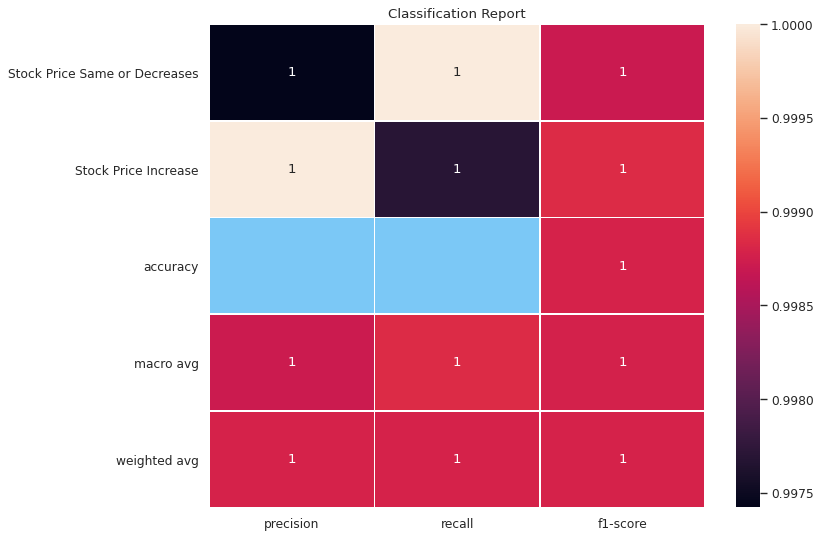

In [74]:
fig, ax = plt.subplots(figsize=(10,8))
g = sns.heatmap(clf, linewidths=.5, annot=True)
g.set_facecolor('xkcd:lightblue')
plt.yticks(rotation=-0) 
plt.title('Classification Report')
plt.show()